In [1]:
import requests        # for making http requests to binance
import json            # for parsing what binance sends back to us
import pandas as pd    # for storing and manipulating the data we get back
import numpy as np     # numerical python, i usually need this somewhere 
                       # and so i import by habit nowadays

import matplotlib.pyplot as plt # for charts and such
import matplotlib.ticker as ticker

import itertools
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from arch import arch_model

import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

from pylab import rcParams

# Initialize plotly
init_notebook_mode(connected=True)

from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

import datetime as dt  # for dealing with times
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [2]:
### CARREGAR OS DFS
df_difficulty = pd.read_csv('datasets/blockchain_explorer/difficulty.csv',header = None, names=['time_stamp', 'difficulty'])
df_estimated_transaction_volume = pd.read_csv('datasets/blockchain_explorer/estimated-transaction-volume.csv',header = None, names=['time_stamp', 't_volume'])
df_hash_rate = pd.read_csv('datasets/blockchain_explorer/hash-rate.csv',header = None, names=['time_stamp', 'hash_rate'])
df_market_price = pd.read_csv('datasets/blockchain_explorer/market-price.csv',header = None, names=['time_stamp', 'market_price'])
df_mempool_coun = pd.read_csv('datasets/blockchain_explorer/mempool-count.csv',header = None, names=['time_stamp', 'mempool_count'])
df_mempool_size = pd.read_csv('datasets/blockchain_explorer/mempool-size.csv',header = None, names=['time_stamp', 'mempool_size'])
df_n_transactions = pd.read_csv('datasets/blockchain_explorer/n-transactions.csv',header = None, names=['time_stamp', 'n_transactions'])
df_transaction_fees = pd.read_csv('datasets/blockchain_explorer/transaction-fees.csv',header = None, names=['time_stamp', 'transaction-fees'])

df_coinmarket_price_1h = pd.read_csv('datasets/cryptodatadownload/Coinbase_BTCUSD_1h.csv', skiprows=1)
df_coinmarket_price_d = pd.read_csv('datasets/cryptodatadownload/Coinbase_BTCUSD_d.csv', skiprows=1)

In [3]:
### TRANSFORMA EM DATETIME

#bitcoinexplorer
df_difficulty['time_stamp'] = pd.to_datetime(df_difficulty['time_stamp'])
df_estimated_transaction_volume['time_stamp'] = pd.to_datetime(df_estimated_transaction_volume['time_stamp'])
df_hash_rate['time_stamp'] = pd.to_datetime(df_hash_rate['time_stamp'])
df_market_price['time_stamp'] = pd.to_datetime(df_market_price['time_stamp'])
df_mempool_coun['time_stamp'] = pd.to_datetime(df_mempool_coun['time_stamp'])
df_mempool_size['time_stamp'] = pd.to_datetime(df_mempool_size['time_stamp'])
df_n_transactions['time_stamp'] = pd.to_datetime(df_n_transactions['time_stamp'])
df_transaction_fees['time_stamp'] = pd.to_datetime(df_transaction_fees['time_stamp'])

#coinmarket
df_coinmarket_price_1h['Date'] = pd.to_datetime(df_coinmarket_price_1h['Date'], format="%Y-%m-%d %I-%p")
df_coinmarket_price_d['Date'] = pd.to_datetime(df_coinmarket_price_d['Date'], format="%Y-%m-%d")

In [4]:
### VISUALIZA OS TEMPOS MAXIMO E MINIMO
print('------------', 'df_difficulty', '------------')
print(df_difficulty['time_stamp'].max())
print(df_difficulty['time_stamp'].min())
print('------------', 'df_estimated_transaction_volume', '------------')
print(df_estimated_transaction_volume['time_stamp'].max())
print(df_estimated_transaction_volume['time_stamp'].min())
print('------------', 'df_hash_rate', '------------')
print(df_hash_rate['time_stamp'].max())
print(df_hash_rate['time_stamp'].min())
print('------------', 'df_market_price', '------------')
print(df_market_price['time_stamp'].max())
print(df_market_price['time_stamp'].min())
print('------------', 'df_mempool_coun', '------------')
print(df_mempool_coun['time_stamp'].max())
print(df_mempool_coun['time_stamp'].min())
print('------------', 'df_mempool_size', '------------')
print(df_mempool_size['time_stamp'].max())
print(df_mempool_size['time_stamp'].min())
print('------------', 'df_n_transactions', '------------')
print(df_n_transactions['time_stamp'].max())
print(df_n_transactions['time_stamp'].min())
print('------------', 'df_transaction_fees', '------------')
print(df_transaction_fees['time_stamp'].max())
print(df_transaction_fees['time_stamp'].min())
print('------------', 'df_coinmarket_price_d', '------------')
print(df_coinmarket_price_d['Date'].max())
print(df_coinmarket_price_d['Date'].min())
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_coinmarket_price_1h['Date'].max())
print(df_coinmarket_price_1h['Date'].min())


------------ df_difficulty ------------
2020-03-08 00:00:00
2009-01-03 00:00:00
------------ df_estimated_transaction_volume ------------
2020-03-10 00:00:00
2010-08-28 00:00:00
------------ df_hash_rate ------------
2020-03-08 00:00:00
2009-01-03 00:00:00
------------ df_market_price ------------
2020-03-09 00:00:00
2009-01-03 00:00:00
------------ df_mempool_coun ------------
2020-03-10 11:30:00
2016-06-14 14:45:00
------------ df_mempool_size ------------
2020-03-10 11:30:00
2016-06-14 14:45:00
------------ df_n_transactions ------------
2020-03-08 00:00:00
2009-01-17 00:00:00
------------ df_transaction_fees ------------
2020-03-08 00:00:00
2009-01-17 00:00:00
------------ df_coinmarket_price_d ------------
2020-04-01 00:00:00
2014-12-01 00:00:00
------------ df_coinmarket_price_1h ------------
2020-04-01 11:00:00
2017-07-01 11:00:00


In [5]:
### VISUALIZA O TAMANHO DOS DF
print('------------', 'df_difficulty', '------------')
print(df_difficulty.shape[0])
print('------------', 'df_estimated_transaction_volume', '------------')
print(df_estimated_transaction_volume.shape[0])
print('------------', 'df_hash_rate', '------------')
print(df_hash_rate.shape[0])
print('------------', 'df_market_price', '------------')
print(df_market_price.shape[0])
print('------------', 'df_mempool_coun', '------------')
print(df_mempool_coun.shape[0])
print('------------', 'df_mempool_size', '------------')
print(df_mempool_size.shape[0])
print('------------', 'df_n_transactions', '------------')
print(df_n_transactions.shape[0])
print('------------', 'df_transaction_fees', '------------')
print(df_transaction_fees.shape[0])
print('------------', 'df_coinmarket_price_d', '------------')
print(df_coinmarket_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_coinmarket_price_1h.shape[0])

------------ df_difficulty ------------
1356
------------ df_estimated_transaction_volume ------------
1735
------------ df_hash_rate ------------
1356
------------ df_market_price ------------
1362
------------ df_mempool_coun ------------
1507
------------ df_mempool_size ------------
1507
------------ df_n_transactions ------------
1357
------------ df_transaction_fees ------------
1357
------------ df_coinmarket_price_d ------------
1937
------------ df_coinmarket_price_1h ------------
24121


In [6]:
# df_difficulty
# df_estimated_transaction_volume
# df_hash_rate
# df_market_price
# df_mempool_coun # time stamp com horas, minutos e segundos
# df_mempool_size # time stamp com horas, minutos e segundos
# df_n_transactions
# df_transaction_fees
#df_coinmarket_price_1h
#df_coinmarket_price_d

In [7]:
# ### JUNTA OS DATAFRAMES

# def set_index(df):
#     return df.set_index('time_stamp')
    
# list_df = [df_market_price, df_difficulty, df_estimated_transaction_volume, df_hash_rate, df_n_transactions, df_transaction_fees]

# for i in range(len(list_df)):
#     list_df[i] = set_index(list_df[i])  

# df_concat = pd.DataFrame([], index=pd.date_range(start='3/1/2009', end='3/10/2020'))
# df_concat = df_concat.join(list_df, how = 'left')
# df_concat.info()

In [8]:
# print(df_concat.shape[0])
# print(df_concat.dropna(how='all').shape[0])
# df_concat.corr()

In [9]:
df = df_coinmarket_price_d.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 8 columns):
Date          1937 non-null datetime64[ns]
Symbol        1937 non-null object
Open          1937 non-null float64
High          1937 non-null float64
Low           1937 non-null float64
Close         1937 non-null float64
Volume BTC    1937 non-null float64
Volume USD    1937 non-null float64
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 121.2+ KB


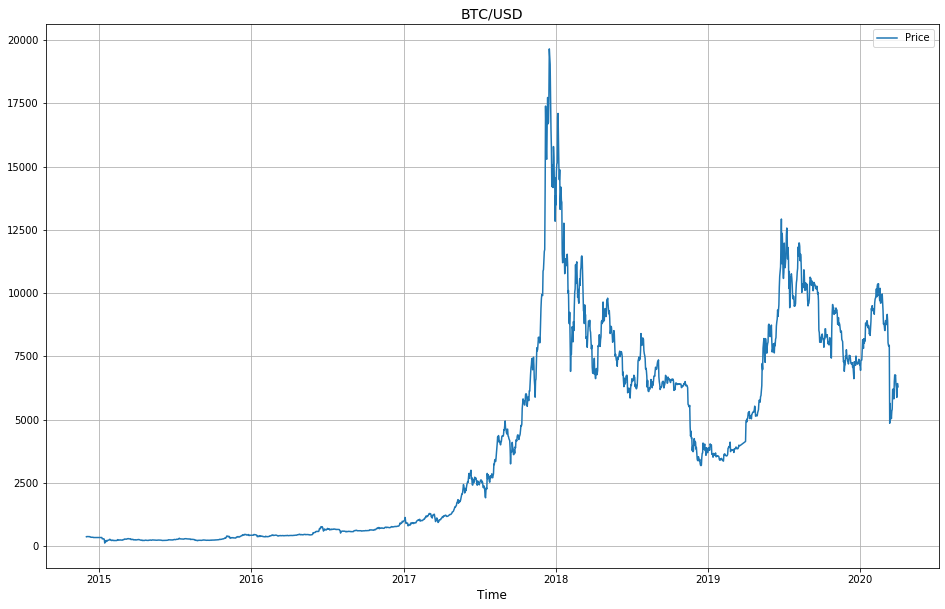

In [7]:
### TESTE GRAFICO
df = df_coinmarket_price_d.copy()
df = df.set_index(df['Date']) #opcional
fig = plt.gcf()
fig.set_size_inches(16,10)
# sns.lineplot(x = 'market_price', y = 'difficulty',  data = df)
plt.plot(df['Close'], label='Price')
#plt.plot(df['Volume USD'], color = 'b', label='volume usd')
#plt.plot(df['Volume BTC'], color = 'r', label='volume btc')
#plt.ylim(6000, 13000)
plt.title('BTC/USD', fontsize = 14)
plt.xlabel('Time', fontsize = 12)
#plt.ylabel('difficulty', fontsize = 12)
plt.grid(True)
plt.legend()
plt.show()

In [8]:
df.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,,
2020-04-01,2020-04-01,BTCUSD,6424.35,6437.57,6260.00,6295.77,6287.24,3.973897e+07
2020-03-31,2020-03-31,BTCUSD,6406.40,6524.79,6333.91,6424.35,11772.78,7.595967e+07
2020-03-30,2020-03-30,BTCUSD,5877.21,6631.23,5853.00,6406.40,22757.77,1.435957e+08
2020-03-29,2020-03-29,BTCUSD,6251.82,6279.96,5870.46,5877.21,15449.07,9.361734e+07
2020-03-28,2020-03-28,BTCUSD,6372.36,6372.36,6030.00,6251.82,19731.24,1.226936e+08


In [11]:
# def _get_best_model(TS):
#     best_aic = np.inf 
#     best_order = None
#     best_mdl = None
#     pq_rng = range(5) # [0,1,2,3,4]
#     d_rng = range(2) # [0,1]
    
#     for i in pq_rng:
#         for d in d_rng:
#             for j in pq_rng:
#                 try:
#                     tmp_mdl = ARIMA(TS, order=(i,d,j)).fit(
#                         method='mle', trend='nc'
#                     )
#                     tmp_aic = tmp_mdl.aic
#                     if tmp_aic < best_aic:
#                         best_aic = tmp_aic
#                         best_order = (i, d, j)
#                         best_mdl = tmp_mdl
                        
#                 except: continue
#     print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))                    
#     return best_aic, best_order, best_mdl
# TS = df['market_price']
# res_tup = _get_best_model(TS)

In [12]:
# order = res_tup[1]
# model = res_tup[2]
# print('order', order)
# print('model', model)

In [13]:
# sns.tsplot(model.resid)
# sm.graphics.tsa.plot_acf(model.resid, lags=40)
# sm.graphics.tsa.plot_pacf(model.resid, lags=40)
# plt.show()

In [14]:
# sns.tsplot(model.resid**2)
# sm.graphics.tsa.plot_acf(model.resid**2, lags=40)
# sm.graphics.tsa.plot_pacf(model.resid**2, lags=40)
# plt.show()

In [15]:
# p_ = order[0]
# o_ = order[1]
# q_ = order[2]

# am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
# res = am.fit(update_freq=5, disp='off')
# print(res.summary())

In [16]:
# # log returns
# lrets = np.log(df['market_price']/df['market_price'].shift(1)).dropna()

In [17]:
# windowLength = 1154
# foreLength = len(lrets) - windowLength
# signal = 0*lrets[-foreLength:]
# #print('foreLength', foreLength)
# #print('signal', signal)

In [18]:
# for d in range(foreLength):
    
#     # create a rolling window by selecting 
#     # values between d+1 and d+T of S&P500 returns
    
#     TS = lrets[(1+d):(windowLength+d)] 
    
#     # Find the best ARIMA fit 
#     # set d = 0 since we've already taken log return of the series
#     res_tup = _get_best_model(TS)
#     order = res_tup[1]
#     model = res_tup[2]
    
#     #now that we have our ARIMA fit, we feed this to GARCH model
#     p_ = order[0]
#     o_ = order[1]
#     q_ = order[2]
    
#     if (p_ == 0) & (o_ == 0):
#         o_ = 1
    
#     am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
#     res = am.fit(update_freq=5, disp='off')
    
#     # Generate a forecast of next day return using our fitted model
#     out = res.forecast(horizon=1, start=None, align='origin')
    
#     #Set trading signal equal to the sign of forecasted return
#     # Buy if we expect positive returns, sell if negative
      
#     signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])

In [19]:
# signal_ = pd.DataFrame(signal).copy()
# returns = pd.DataFrame(index = signal_.index, 
#                        columns=['Buy and Hold', 'Strategy'])
# returns['Buy and Hold'] = lrets[-foreLength:]
# returns['Strategy'] = signal_['market_price']*returns['Buy and Hold']
# eqCurves = pd.DataFrame(index = signal_.index, 
#                        columns=['Buy and Hold', 'Strategy'])
# eqCurves['Buy and Hold']=returns['Buy and Hold'].cumsum()+1
# eqCurves['Strategy'] = returns['Strategy'].cumsum()+1
# eqCurves['Strategy'].plot(figsize=(10,8))
# eqCurves['Buy and Hold'].plot()
# plt.legend()
# plt.show()

# SARIMA TESTE

In [20]:
df = df_market_price.copy()
df.isnull().sum()

time_stamp      0
market_price    0
dtype: int64

In [21]:
df = df.set_index('time_stamp')
df.head()

,market_price
time_stamp,
2009-01-03,0.0
2009-01-06,0.0
2009-01-09,0.0
2009-01-12,0.0
2009-01-15,0.0


In [22]:
#filter irrelevant values
df = df['2013':]

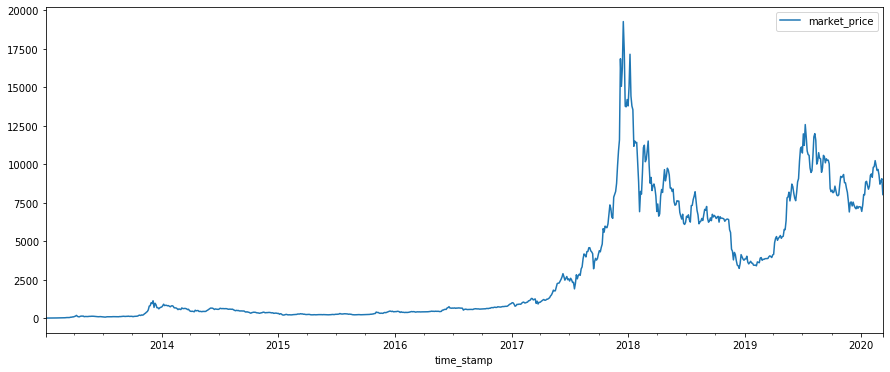

In [23]:
df.plot(figsize=(15, 6))
plt.show()

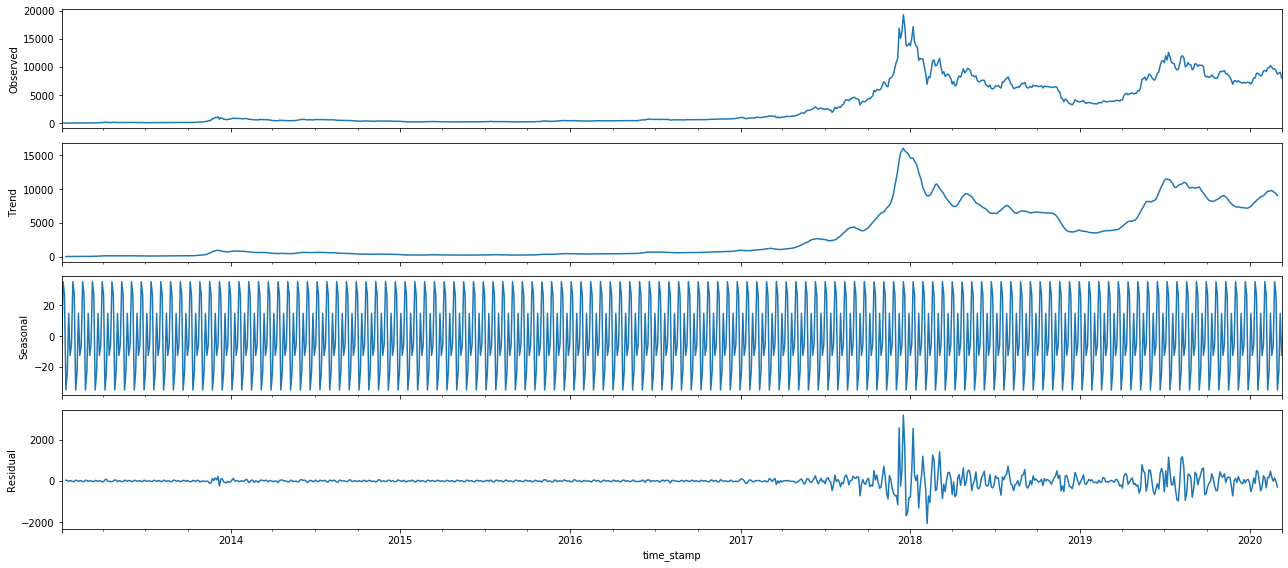

In [24]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

In [25]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
print('pdq', pdq)

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
pdq [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [26]:
best_aic = 90000
param_ = 0
param_seasonal_ = 0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=(1, 1, 1, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    
            if results.aic < best_aic:
                best_aic = results.aic
                param_ = param
                param_seasonal_ = param_seasonal
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                
            
            
        except:
            continue
            
print('ideal', param_, param_seasonal_, best_aic)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:14874.40585900646
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:14046.06689056136
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:12748.868483457212
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:12735.790578567265
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:12729.442158713047
ideal (1, 1, 1) (0, 0, 0, 12) 12729.442158713047


In [27]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6339      0.053    -11.923      0.000      -0.738      -0.530
ma.L1          0.7161      0.049     14.529      0.000       0.620       0.813
ar.S.L12      -0.0780      0.017     -4.478      0.000      -0.112      -0.044
ma.S.L12      -1.0000      0.011    -89.353      0.000      -1.022      -0.978
sigma2       1.82e+05   6.15e-08   2.96e+12      0.000    1.82e+05    1.82e+05


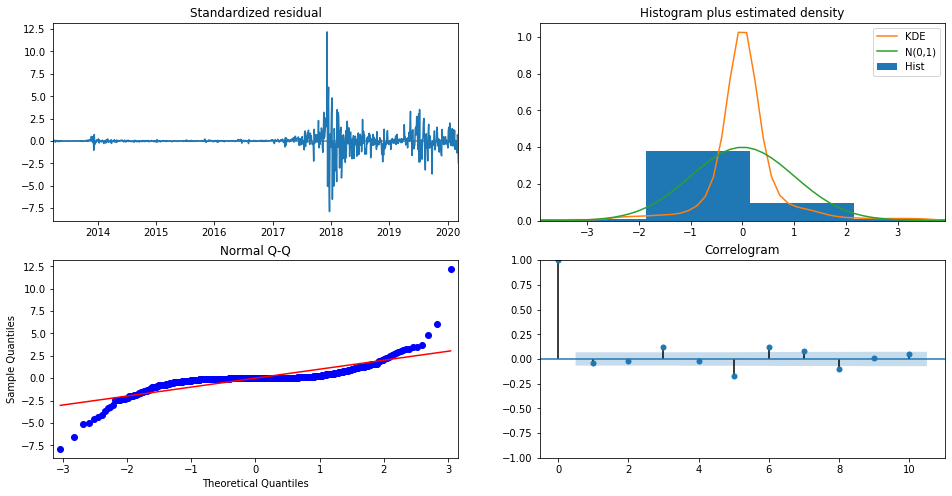

In [28]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

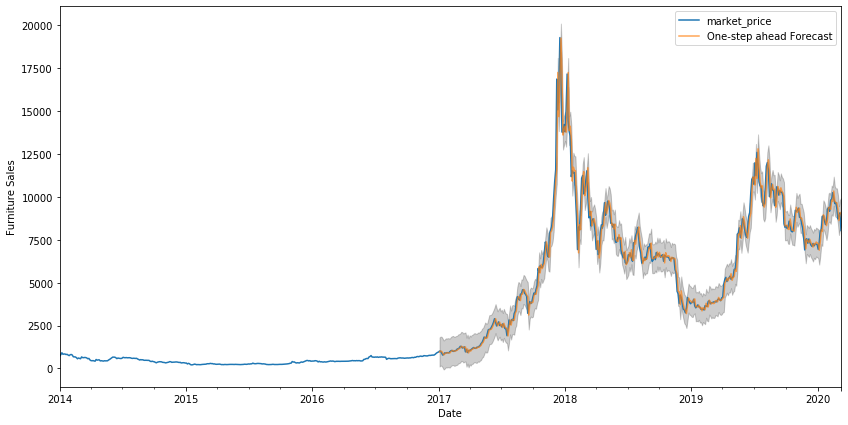

In [29]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-03'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [30]:
y_forecasted = pred.predicted_mean
y_truth = df['2017-01-03':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2017-01-03 00:00:00   NaN
2017-01-06 00:00:00   NaN
2017-01-09 00:00:00   NaN
2017-01-12 00:00:00   NaN
2017-01-15 00:00:00   NaN
                       ..
2020-02-29 00:00:00   NaN
2020-03-03 00:00:00   NaN
2020-03-06 00:00:00   NaN
2020-03-09 00:00:00   NaN
market_price          NaN
Length: 389, dtype: float64


In [31]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2017-01-03 00:00:00   NaN
2017-01-06 00:00:00   NaN
2017-01-09 00:00:00   NaN
2017-01-12 00:00:00   NaN
2017-01-15 00:00:00   NaN
                       ..
2020-02-29 00:00:00   NaN
2020-03-03 00:00:00   NaN
2020-03-06 00:00:00   NaN
2020-03-09 00:00:00   NaN
market_price          NaN
Length: 389, dtype: float64


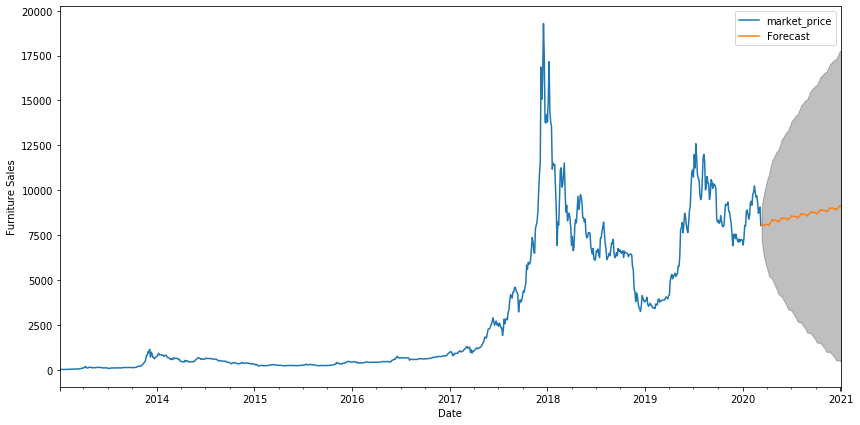

In [32]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# ARIMA TESTE

In [10]:
df = df_market_price.copy()
df.isnull().sum()

df = df.set_index('time_stamp')
df.head()

#filter irrelevant values
df = df['2013':]

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2020-04-01,BTCUSD,6424.35,6437.57,6260.00,6295.77,6287.24,3.973897e+07
2020-03-31,BTCUSD,6406.40,6524.79,6333.91,6424.35,11772.78,7.595967e+07
2020-03-30,BTCUSD,5877.21,6631.23,5853.00,6406.40,22757.77,1.435957e+08
2020-03-29,BTCUSD,6251.82,6279.96,5870.46,5877.21,15449.07,9.361734e+07
2020-03-28,BTCUSD,6372.36,6372.36,6030.00,6251.82,19731.24,1.226936e+08


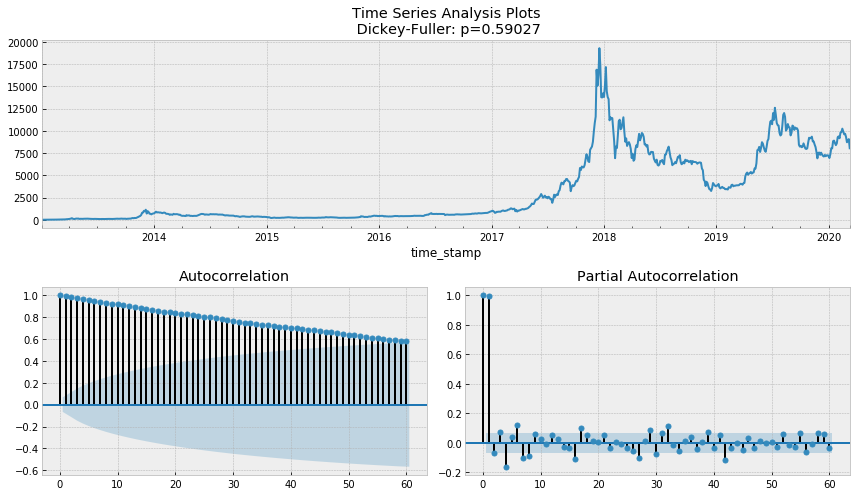

In [34]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df['market_price'], lags=60)

aic: 12980.14 | order: (2, 2, 4)


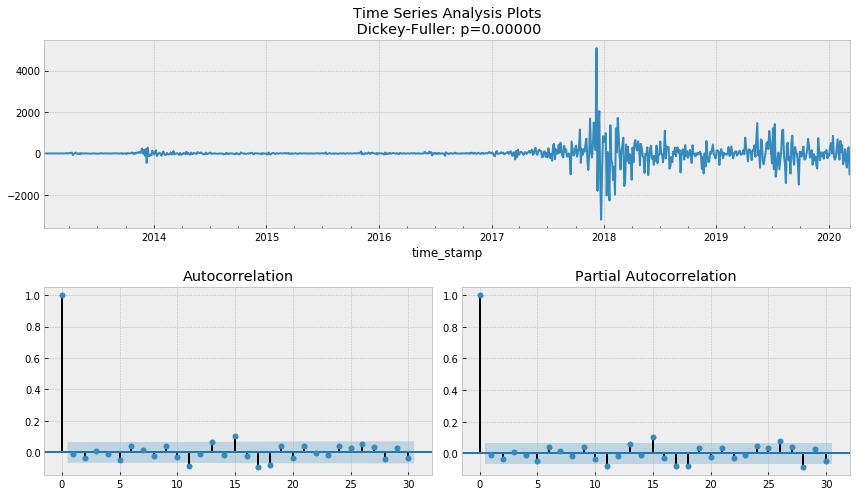

In [35]:
# Fit ARIMA(p, d, q) model
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3]
d_rng = range(3) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(df, 
                                    order=(i,d,j)).fit(method='mle',
                                    trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: %6.2f | order: %s'%(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [36]:
# print(sm.stats.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False))

# from statsmodels.stats.stattools import jarque_bera

# score, pvalue, _, _ = jarque_bera(best_mdl.resid)

# if pvalue < 0.10:
#     print('The residuals may not be normally distributed.')
# else:
#     print ('The residuals seem normally distributed.')

(array([44.14791193]), array([0.00143778]))
The residuals may not be normally distributed.


In [37]:
# end = '2019-03-05'
# start = '2017-01-01'
# symbols = ['market_price']
# #data = dl.load_data_nologs('nasdaq', symbols , start, end)['ADJ CLOSE']
# data = df[start:end][symbols]
# # log returns
# data_returns = np.log(data/data.shift(1)).dropna()

In [38]:
# # Fit ARIMA(p, d, q) model
# # pick best order and final model based on aic

# best_aic = np.inf 
# best_order = None
# best_mdl = None

# pq_rng = range(5) # [0,1,2,3]
# d_rng = range(3) # [0,1]
# for i in pq_rng:
#     for d in d_rng:
#         for j in pq_rng:
#             try:
#                 tmp_mdl = smt.ARIMA(data_returns, 
#                                     order=(i,d,j)).fit(method='mle',
#                                     trend='nc')
#                 tmp_aic = tmp_mdl.aic
#                 if tmp_aic < best_aic:
#                     best_aic = tmp_aic
#                     best_order = (i, d, j)
#                     best_mdl = tmp_mdl
#             except: continue


# print('aic: %6.2f | order: %s'%(best_aic, best_order))

# # ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

In [39]:
# print(sm.stats.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False))

# from statsmodels.stats.stattools import jarque_bera

# score, pvalue, _, _ = jarque_bera(best_mdl.resid)

# if pvalue < 0.10:
#     print('The residuals may not be normally distributed.')
# else:
#     print ('The residuals seem normally distributed.')

(array([44.14791193]), array([0.00143778]))
The residuals may not be normally distributed.


In [40]:
# # Create a 21 day forecast of SPY returns with 95%, 99% CI
# n_steps = 100

# f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
# _, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% 

# idx = pd.date_range(df.index[-1], periods=n_steps, freq='D')
# fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=
#                      ['forecast', 'lower_95', 'upper_95'])

# fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=
#                      ['lower_99', 'upper_99'])
# fc_all = fc_95.combine_first(fc_99)
# fc_all.head()

,forecast,lower_95,lower_99,upper_95,upper_99
2020-03-09,8194.142781,7401.197646,7152.036227,8987.087916,9236.249336
2020-03-10,8180.384755,7021.177467,6656.928138,9339.592044,9703.841373
2020-03-11,7865.168243,6410.246087,5953.076412,9320.090399,9777.260074
2020-03-12,8002.322152,6248.137136,5696.932255,9756.507168,10307.712048
2020-03-13,8265.577876,6286.152120,5664.171469,10245.003632,10866.984283


In [41]:
df.iloc[-1]

market_price    8039.38
Name: 2020-03-09 00:00:00, dtype: float64

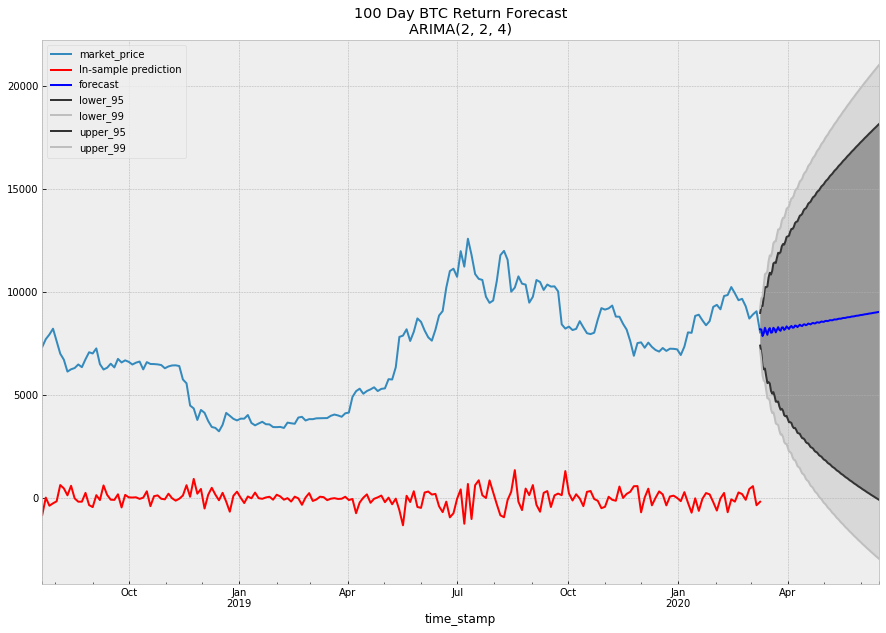

In [42]:
# # Plot 21 day forecast for SPX returns
# plt.style.use('bmh')
# fig = plt.figure(figsize=(15,10))
# ax = plt.gca()
# ts = df.iloc[-200:].copy()
# ts.plot(ax=ax, label='SPX Returns')
# # in sample prediction
# pred = best_mdl.predict(ts.index[0], ts.index[-1])
# pred.plot(ax=ax, style='r-', label='In-sample prediction')
# styles = ['b-', '0.2', '0.75', '0.2', '0.75']
# fc_all.plot(ax=ax, style=styles)
# plt.fill_between(fc_all.index, fc_all.lower_95, 
#                  fc_all.upper_95, color='gray', alpha=0.7)
# plt.fill_between(fc_all.index, fc_all.lower_99, 
#                  fc_all.upper_99, color='gray', alpha=0.2)
# plt.title('{} Day BTC Return Forecast\nARIMA{}'.format(n_steps,
#                  best_order))
# plt.legend(loc='best', fontsize=10)

In [43]:
# mod = sm.tsa.statespace.SARIMAX(df,
#                                 order=(2, 2, 4),
#                                 seasonal_order=(0, 0, 0, 0),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)

# results = mod.fit()
# print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3281      0.012    -26.922      0.000      -0.352      -0.304
ar.L2         -0.9011      0.012    -77.425      0.000      -0.924      -0.878
ma.L1         -0.6059      0.020    -30.809      0.000      -0.644      -0.567
ma.L2          0.5695      0.019     29.447      0.000       0.532       0.607
ma.L3         -0.7579      0.019    -39.650      0.000      -0.795      -0.720
ma.L4         -0.2043      0.016    -13.041      0.000      -0.235      -0.174
sigma2      1.883e+05   3510.795     53.628      0.000    1.81e+05    1.95e+05


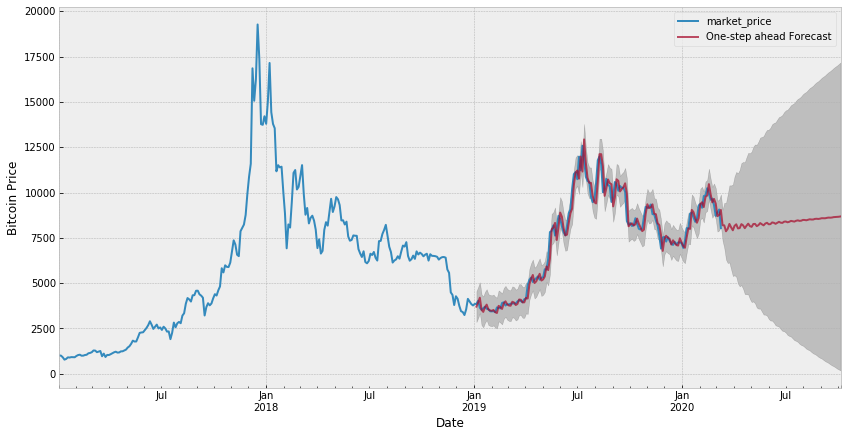

In [44]:
# pred = results.get_prediction(start=pd.to_datetime('2019-01-05'), end=pd.to_datetime('2020-10-05'), dynamic=False)
# pred_ci = pred.conf_int()
# ax = df['2017':].plot(label='observed')
# pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
# ax.set_xlabel('Date')
# ax.set_ylabel('Bitcoin Price')
# plt.legend()
# plt.show()

### ARIMA RESUMIDO

In [10]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')

        self.pValue = adfTest[1]

        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False

        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

null
 Date          0
Symbol        0
Open          0
High          0
Low           0
Close         0
Volume BTC    0
Volume USD    0
dtype: int64
df head
               Close
Date               
2020-04-01  6295.77
2020-03-31  6424.35
2020-03-30  6406.40
2020-03-29  5877.21
2020-03-28  6251.82
df index <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
df <class 'pandas.core.frame.DataFrame'>


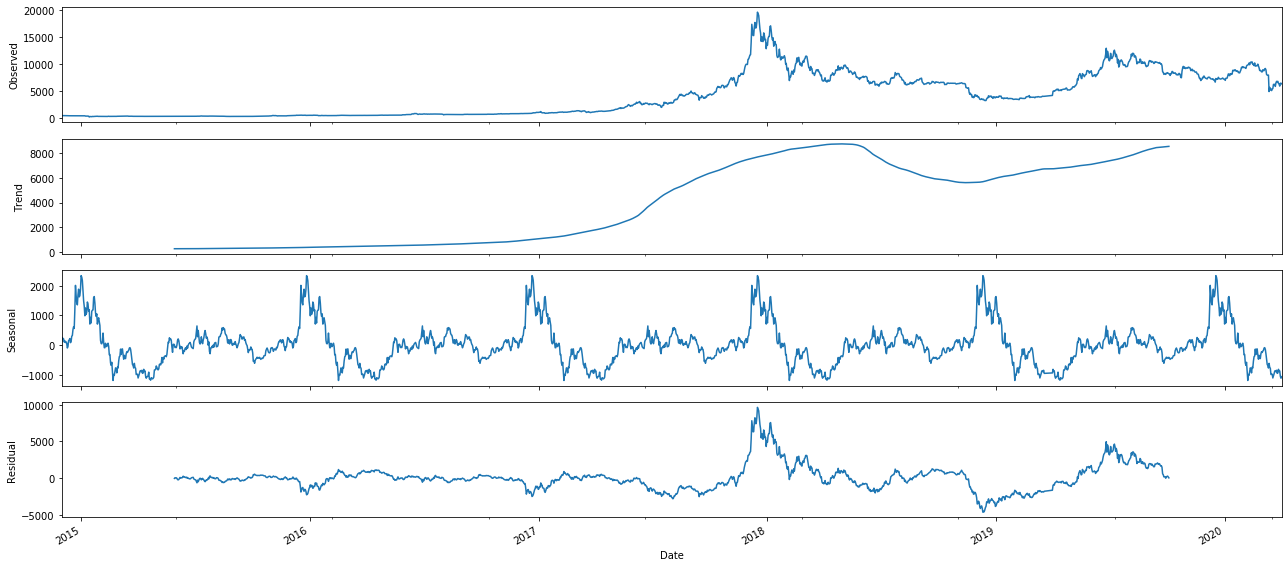

In [11]:
#df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
print('df head\n', df.head())
print('df index', type(df.index))
print('df', type(df))

#pd.plotting.register_matplotlib_converters()
model = ['multiplicative', 'additive']
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x = df, model = model[1], freq = 360)
fig = decomposition.plot()
plt.show()

len df 1937
len df 80%, len df 20% 1549.6000000000001 387.40000000000003
ARIMA- AIC:22223.427907615624


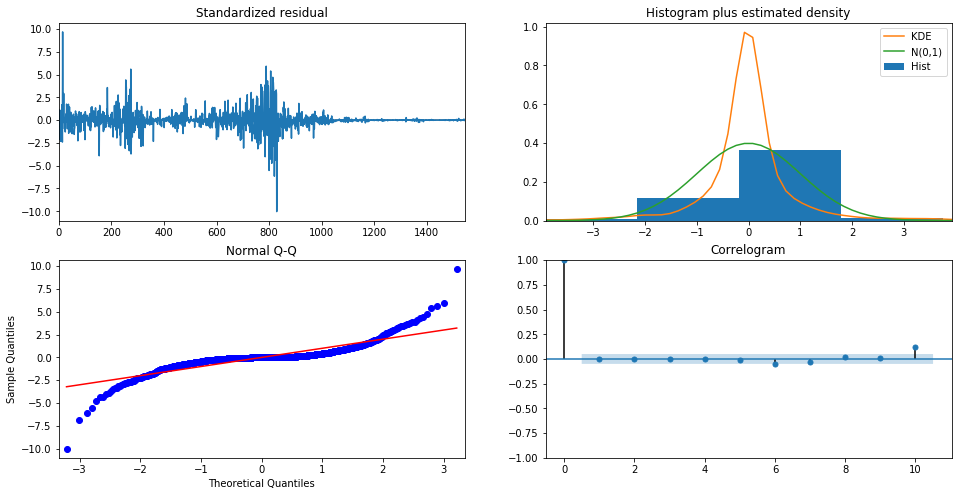

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.462742e+00
P-Value                 5.301031e-11
# Lags Used             2.400000e+01
# Observations Used     1.525000e+03
Critical Value (1%)    -3.434645e+00
Critical Value (5%)    -2.863437e+00
Critical Value (10%)   -2.567780e+00
dtype: float64
Is the time series stationary? True
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0047      0.010      0.465      0.642      -0.015       0.024
ar.L2          0.0002      0.013      0.017      0.986      -0.026       0.027
ar.L3         -0.0007      0.013     -0.060      0.952      -0.025       0.024
ar.L4         -0.0013      0.011     -0.117      0.906      -0.023       0.020
ar.L5          0.0926      0.012      7.505      0.000       0.068       0.117
sigma2      1.035e+05   1250.369     82.812      0.000    1.01e+05    1.06e+05


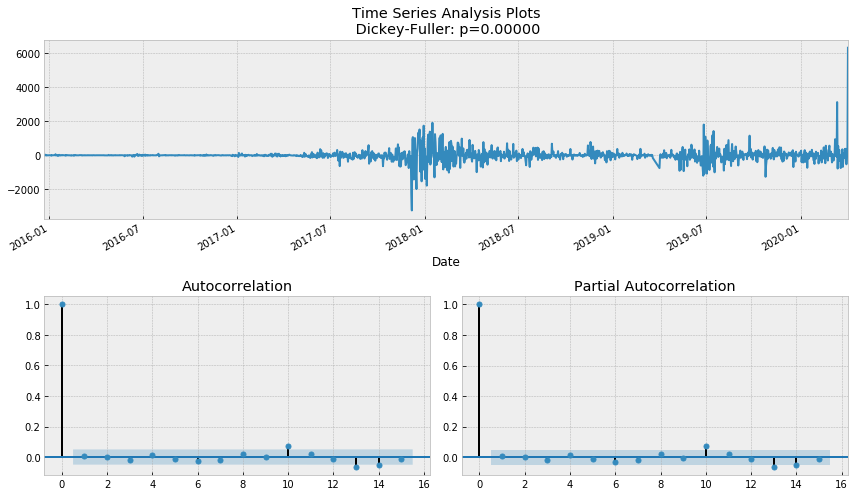

In [12]:
print('len df', len(df))
print('len df 80%, len df 20%', len(df)*0.8, len(df)*0.2)
#-int(len(df)*0.2)

mod = sm.tsa.statespace.SARIMAX(df.iloc[:-int(len(df)*0.2)],
                                order=(5,1,0),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('ARIMA- AIC:{}'.format(results.aic))

results.plot_diagnostics(figsize=(16, 8))
plt.show()

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(results.resid, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

print(results.summary().tables[1])
tsplot(results.resid, lags=15)

#df.iloc[:].plot(grid=True, title='last 10 days - Simple visualization')
#plt.show()

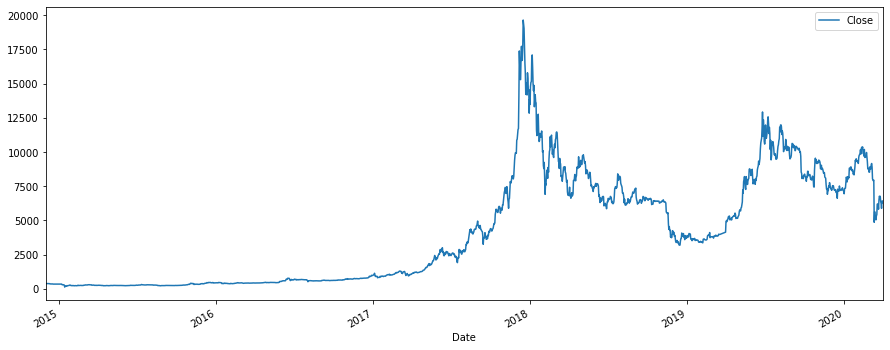

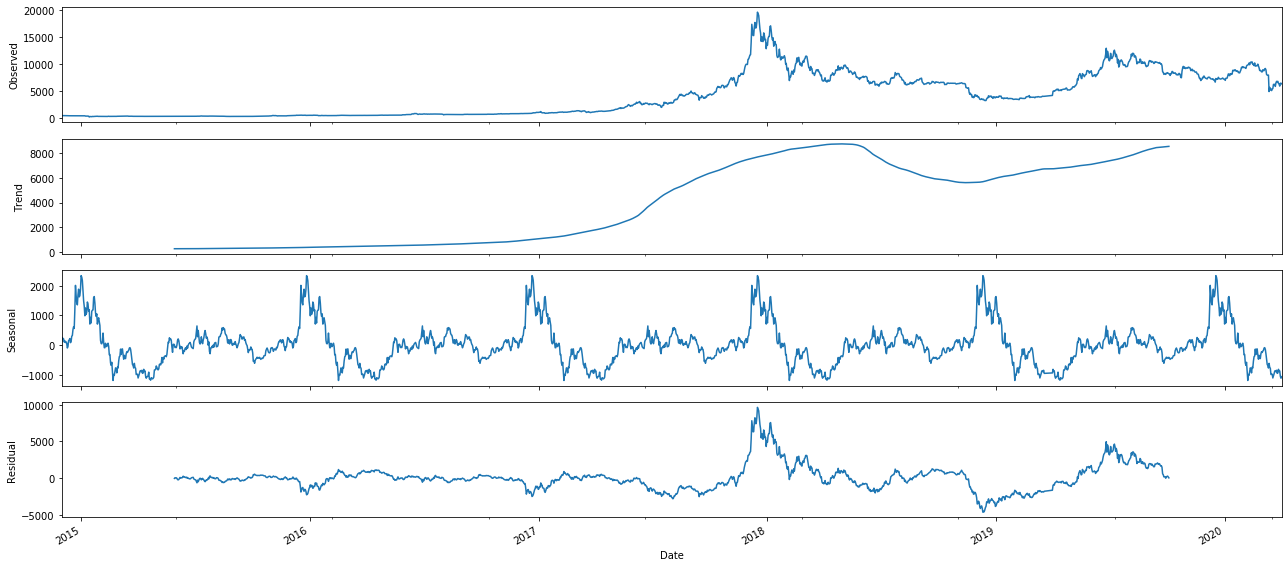

len df 1937
len 1551
aic: 22227.33 | order: [2, 2, 4]
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1831      0.010   -120.106      0.000      -1.202      -1.164
ar.L2         -0.9710      0.010    -97.980      0.000      -0.990      -0.952
ma.L1          0.1980      0.021      9.241      0.000       0.156       0.240
ma.L2         -0.1803      0.022     -8.258      0.000      -0.223      -0.138
ma.L3         -0.9879      0.020    -48.368      0.000      -1.028      -0.948
ma.L4         -0.0289      0.012     -2.370      0.018      -0.053      -0.005
sigma2      1.113e+05   2750.778     40.462      0.000    1.06e+05    1.17e+05


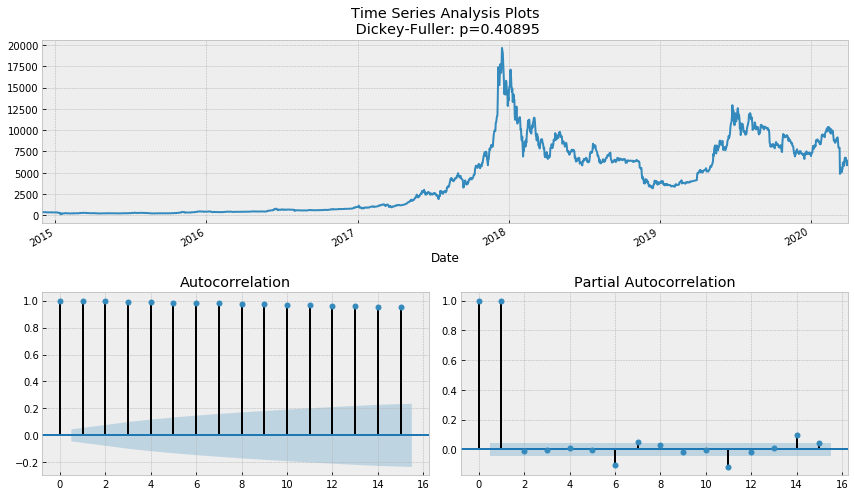

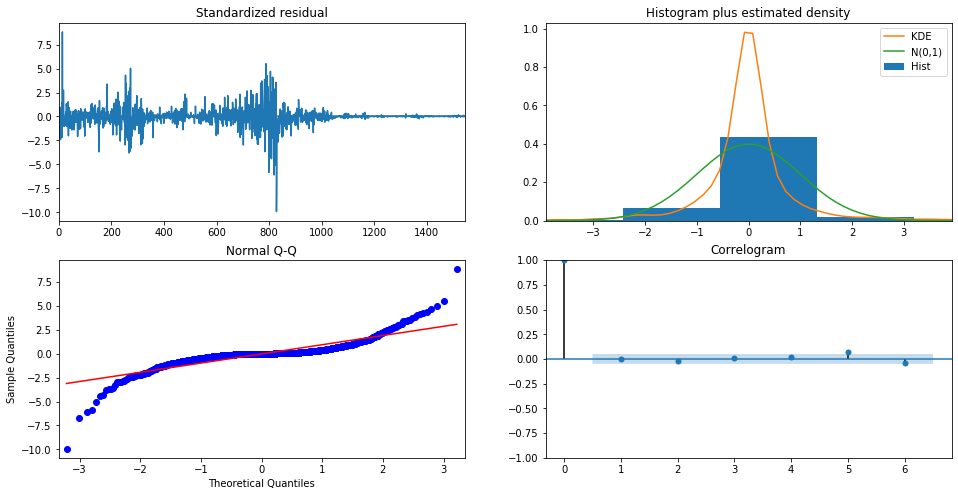

ValueError: year 0 is out of range

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f24f3ed5830> (for post_execute):


ValueError: year 0 is out of range

ValueError: year 0 is out of range

In [14]:
#### resumindo passos anteriores
cut_index = int(len(df)*0.2)-1

df.plot(figsize=(15, 6))
plt.show()

rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq = 360)
fig = decomposition.plot()
plt.show()

print('len df', len(df))        
tsplot(df['Close'], lags=15)

method = ['css-mle', 'mle', 'css']
def fit_arima(y):

    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3]
    d_rng = range(3) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = sm.tsa.statespace.SARIMAX(y,
                                order=(i, d, j),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                    results = tmp_mdl.fit()
                    
                    tmp_aic = results.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = [i, d, j]
                        best_mdl = tmp_mdl
                except: continue


    print('aic: %6.2f | order: %s'%(best_aic, best_order))
    
    return best_mdl, best_order
    
    
y = df.iloc[:-cut_index]
print('len', len(y))
best_mdl, best_order = fit_arima(y)
#_ = tsplot(best_mdl.resid, lags=10)

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(best_order[0], best_order[1], best_order[2]),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(lags =6, figsize=(16, 8))
plt.show()

pred_uc = results.get_forecast(steps=cut_index)
pred_ci = pred_uc.conf_int()

pred_uc_train = results.get_prediction() #
pred_ci_train = pred_uc_train.conf_int() #

ax = df.iloc[:].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
pred_uc_train.predicted_mean.plot(ax=ax, label='model_curve') #
ax.fill_between(pred_ci_train.index, #
                pred_ci_train.iloc[:, 0], #
                pred_ci_train.iloc[:, 1], color='k', alpha=.25) #
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

#metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_forecasted = pred_uc.predicted_mean.values.reshape(-1,1)
y_truth = df[pred_uc.predicted_mean.index[0]: pred_uc.predicted_mean.index[-1]].values
print('len forecast', len(y_truth) ,len(y_forecasted))

print("y_truth\n", df[pred_uc.predicted_mean.index[0]: pred_uc.predicted_mean.index[-1]][:])
print("y_forecasted\n", y_forecasted[:])

print('MAPE forecast', mean_absolute_percentage_error(y_truth, y_forecasted))

y_forecasted = pred_uc_train.predicted_mean.values.reshape(-1,1)
y_truth = df[pred_uc_train.predicted_mean.index[0]: pred_uc_train.predicted_mean.index[-1]].values

print('MAPE train', mean_absolute_percentage_error(y_truth, y_forecasted))
print('order', best_order)




## PROPHET

In [50]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [52]:
plotly_df(df, title='BTC price')

In [54]:
df_prophet = df.reset_index().copy()
df_prophet.columns = ['ds', 'y']
df_prophet.tail(n=3)

,ds,y
872,2020-03-03,8912.82
873,2020-03-06,9067.39
874,2020-03-09,8039.38


In [55]:
prediction_size = 30
train_df = df_prophet[:-prediction_size]
train_df.tail(n=3)

,ds,y
842,2019-12-04,7296.77
843,2019-12-07,7547.19
844,2019-12-10,7337.42


In [56]:
m = Prophet()
m.fit(train_df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
872,2020-01-07
873,2020-01-08
874,2020-01-09


In [58]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
872,2020-01-07,7679.023829,5981.923906,10539.713788,7676.611956,7682.829446,519.874676,519.874676,519.874676,-27.517705,-27.517705,-27.517705,547.392381,547.392381,547.392381,0.0,0.0,0.0,8198.898505
873,2020-01-08,7679.613620,5945.133038,10492.069343,7676.910308,7683.650017,543.911755,543.911755,543.911755,22.999792,22.999792,22.999792,520.911963,520.911963,520.911963,0.0,0.0,0.0,8223.525375
874,2020-01-09,7680.203410,5974.464686,10563.895450,7677.036151,7684.809157,483.890932,483.890932,483.890932,-10.946823,-10.946823,-10.946823,494.837755,494.837755,494.837755,0.0,0.0,0.0,8164.094342


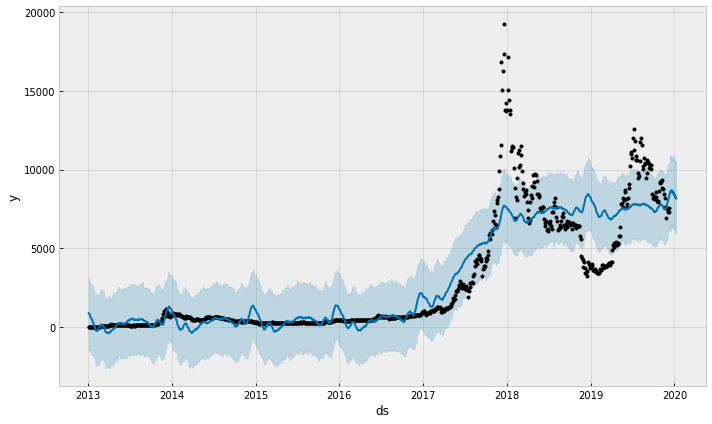

In [59]:
m.plot(forecast);

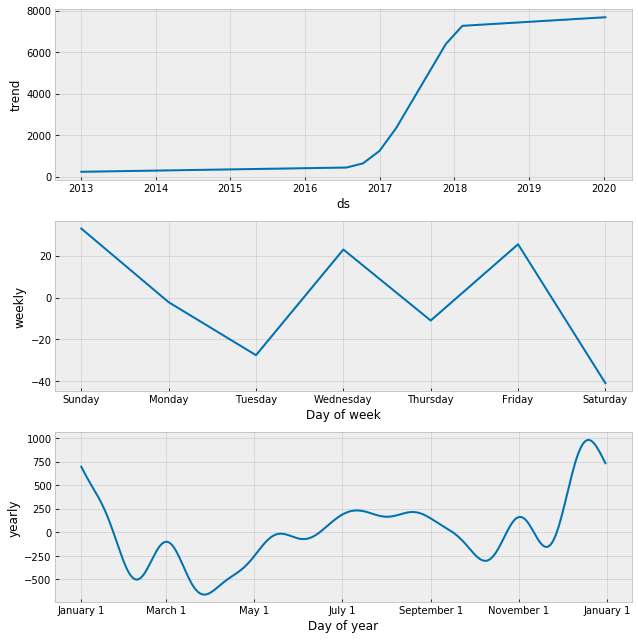

In [60]:
m.plot_components(forecast);

In [61]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [62]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))


In [63]:
cmp_df = make_comparison_dataframe(df_prophet, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-01-07,8198.898505,5981.923906,10539.713788,NaN
2020-01-08,8223.525375,5945.133038,10492.069343,NaN
2020-01-09,8164.094342,5974.464686,10563.895450,8042.65


In [64]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [66]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 16.605326889587765
MAE 1193.7842080371108


In [70]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="#ff0000"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="#ff0000"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'BTC forecast')

In [71]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [72]:
train_df2 = train_df.copy().set_index('ds')

In [73]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

In [74]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column],
                                       lambda_prophet)

In [76]:
cmp_df2 = make_comparison_dataframe(df_prophet, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
     print(err_name, err_value)

MAPE 24.264761408132323
MAE 1744.8161677593096


In [77]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'Box–Cox transformation')

null
 Date          0
Symbol        0
Open          0
High          0
Low           0
Close         0
Volume BTC    0
Volume USD    0
dtype: int64
df head
             Close
Date             
2014-12-01  370.0
2014-12-02  378.0
2014-12-03  378.0
2014-12-04  377.1
2014-12-05  377.1


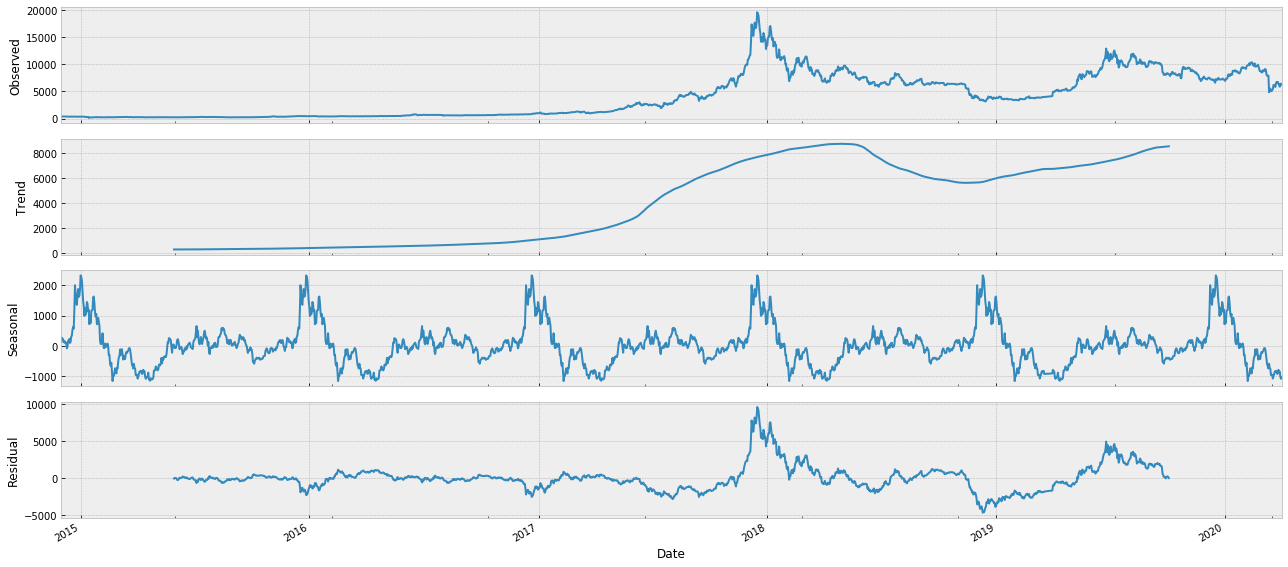

aic: 21638.41 | order: (1, 2, 2)
(array([185.61336129]), array([7.70511972e-29]))
The residuals may not be normally distributed.


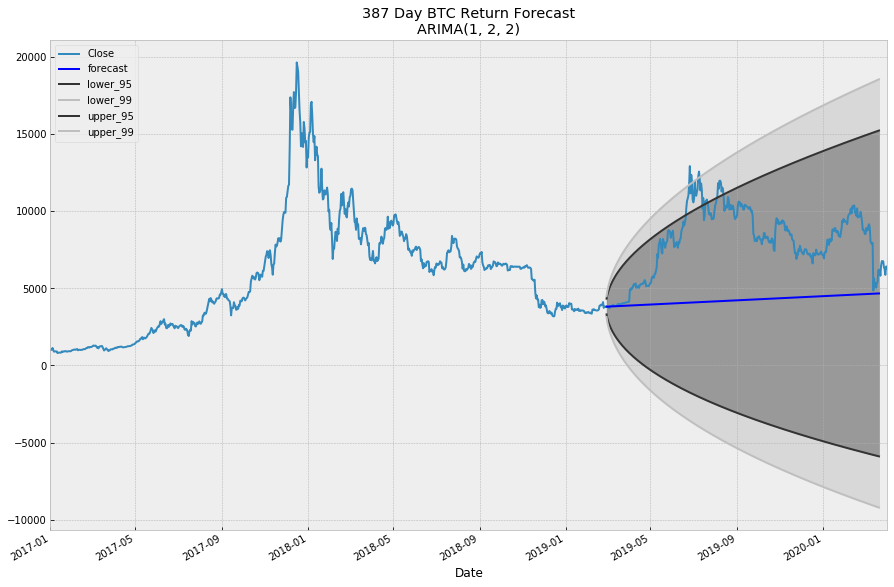

In [23]:
#df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])
#print('df head\n', df.head())

#pd.plotting.register_matplotlib_converters()
model = ['multiplicative', 'additive']
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x = df, model = model[1], freq = 360)
fig = decomposition.plot()
plt.show()

# Fit ARIMA(p, d, q) model
# pick best order and final model based on aic

cut_index = int(len(df)*0.20)

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(3) # [0,1,2,3]
d_rng = range(3) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(df.iloc[:-cut_index], 
                                    order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: %6.2f | order: %s'%(best_aic, best_order))

# ARIMA model resid plot
#_ = tsplot(best_mdl.resid, lags=30)

print(sm.stats.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False))

from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(best_mdl.resid)

if pvalue < 0.10:
    print('The residuals may not be normally distributed.')
else:
    print ('The residuals seem normally distributed.')

# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = cut_index

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% 

idx = pd.date_range(df.index[-cut_index], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=
                     ['forecast', 'lower_95', 'upper_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=
                     ['lower_99', 'upper_99'])



fc_all = fc_95.combine_first(fc_99)
fc_all.head()

# Plot 21 day forecast for SPX returns
plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = df['2017':].copy()
ts.plot(ax=ax, label='Close')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_95, 
                 fc_all.upper_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_99, 
                 fc_all.upper_99, color='gray', alpha=0.2)
plt.title('{} Day BTC Return Forecast\nARIMA{}'.format(n_steps,
                                                       best_order))
plt.legend(loc='best', fontsize=10)
plt.show()

aic: 21348.19 | order: (9, 1, 8)
last_index 2019-02-28 00:00:00
pred 3764.0967655955
last_index 2019-03-01 00:00:00
pred 3887.5003143497793
last_index 2019-03-02 00:00:00
pred 3784.433110131534
last_index 2019-03-03 00:00:00
pred 3689.3383854841572
last_index 2019-03-04 00:00:00
pred 3633.430979257704
last_index 2019-03-05 00:00:00
pred 3769.319903661837
last_index 2019-03-06 00:00:00
pred 3808.201915085132
last_index 2019-03-07 00:00:00
pred 3834.7047796625397
last_index 2019-03-08 00:00:00
pred 3871.489274726499
last_index 2019-03-09 00:00:00
pred 4014.6879177201945
last_index 2019-03-10 00:00:00
pred 3969.9391004816716
last_index 2019-03-11 00:00:00
pred 3946.8026961315613
last_index 2019-03-12 00:00:00
pred 3898.4631960903116
last_index 2019-03-13 00:00:00
pred 3918.6261596992795
last_index 2019-03-14 00:00:00
pred 3836.1767877328116
last_index 2019-03-15 00:00:00
pred 3815.4046587903204
last_index 2019-03-16 00:00:00
pred 3963.8044585802645
last_index 2019-03-17 00:00:00
pred 3845

last_index 2019-08-10 00:00:00
pred 11119.400225408175
last_index 2019-08-11 00:00:00
pred 11503.841589330836
last_index 2019-08-12 00:00:00
pred 11157.15985864542
last_index 2019-08-13 00:00:00
pred 10755.236204473162
last_index 2019-08-14 00:00:00
pred 9816.021554288514
last_index 2019-08-15 00:00:00
pred 10351.595738775777
last_index 2019-08-16 00:00:00
pred 10360.042581169364
last_index 2019-08-17 00:00:00
pred 10209.11207405101
last_index 2019-08-18 00:00:00
pred 10469.597648385019
last_index 2019-08-19 00:00:00
pred 11052.599221329438
last_index 2019-08-20 00:00:00
pred 10881.957221037994
last_index 2019-08-21 00:00:00
pred 10122.922449817206
last_index 2019-08-22 00:00:00
pred 10136.743526158498
last_index 2019-08-23 00:00:00
pred 10274.654186208472
last_index 2019-08-24 00:00:00
pred 9913.08029714833
last_index 2019-08-25 00:00:00
pred 10004.24866487599
last_index 2019-08-26 00:00:00
pred 10329.314910323166
last_index 2019-08-27 00:00:00
pred 10239.498186371478
last_index 2019-

last_index 2020-01-09 00:00:00
pred 7849.03210168154
last_index 2020-01-10 00:00:00
pred 8267.413377502942
last_index 2020-01-11 00:00:00
pred 7992.418513608704
last_index 2020-01-12 00:00:00
pred 8188.908289986568
last_index 2020-01-13 00:00:00
pred 8046.658490908155
last_index 2020-01-14 00:00:00
pred 8941.781196514363
last_index 2020-01-15 00:00:00
pred 8694.767604513432
last_index 2020-01-16 00:00:00
pred 8776.311133821742
last_index 2020-01-17 00:00:00
pred 8863.130887959436
last_index 2020-01-18 00:00:00
pred 8931.485753189561
last_index 2020-01-19 00:00:00
pred 8681.362937898919
last_index 2020-01-20 00:00:00
pred 8598.65803110595
last_index 2020-01-21 00:00:00
pred 8854.627293045904
last_index 2020-01-22 00:00:00
pred 8651.858051848832
last_index 2020-01-23 00:00:00
pred 8459.00391578847
last_index 2020-01-24 00:00:00
pred 8439.754339036037
last_index 2020-01-25 00:00:00
pred 8303.582127454962
last_index 2020-01-26 00:00:00
pred 8523.83975149216
last_index 2020-01-27 00:00:00
p

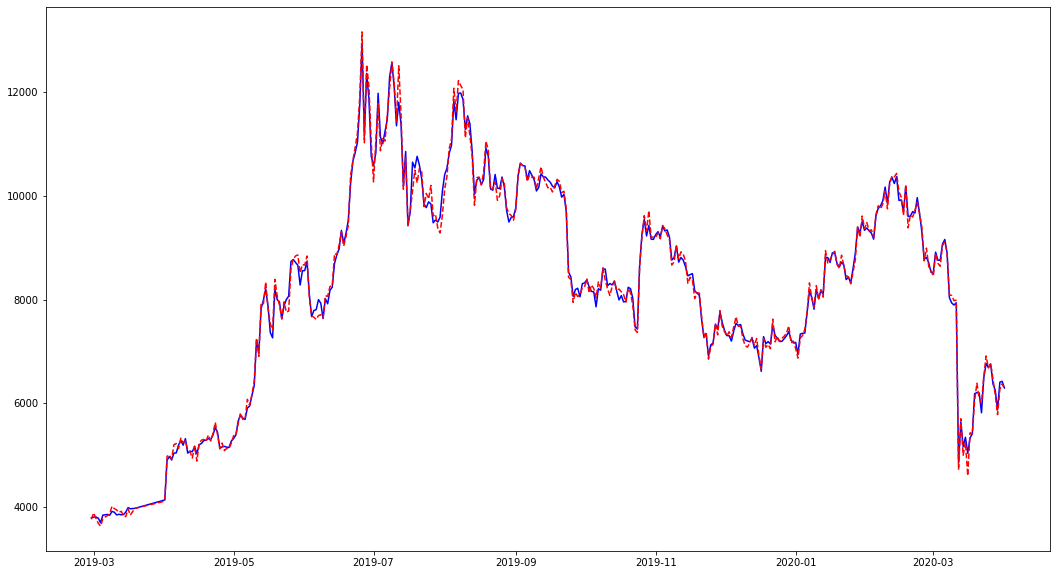

In [17]:
class ARIMAForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred = self.prediction(best_order = best_order, last_index = row[0])
            array_pred = np.append(array_pred, pred.values)
            print('last_index', row[0])
            print('pred', pred.values[0])
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['Close'].values)
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        mape = self.mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred)
        print('mape', mape)
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def mean_absolute_percentage_error(self, y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    def prediction(self, best_order, last_index):
        
        mod = sm.tsa.statespace.SARIMAX(self.df[:last_index],
                                        order=(best_order[0], best_order[1], best_order[2]),
                                        seasonal_order=(0, 0, 0, 0),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        pred = results.forecast(steps = 1)
    
        return pred
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None

        pq_rng = range(10) # [0,1,2,3]
        d_rng = range(3) # [0,1]
        for i in pq_rng:
            for d in d_rng:
                for j in pq_rng:
                    try:
                        mod = sm.tsa.statespace.SARIMAX(self.df.iloc[:-last_index],
                                                        order=(i, d, j),
                                                        seasonal_order=(0, 0, 0, 0),
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False)

                        results = mod.fit()

                        tmp_aic = results.aic
                        if tmp_aic < best_aic:
                            best_aic = tmp_aic
                            best_order = (i, d, j)
                            best_mdl = mod #não esta sendo utilizado
                    except: continue



        print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return best_order, last_index
    
### MAIN

#df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])


arima_forecast = ARIMAForecast(df = df, 
                               percentage_train_size = 0.80)
arima_forecast.perform()



In [ ]:
#80 de treino -387 dias
#mape 32.14530360454009
#order (9, 1, 8)
#aic: 21616.68 

AIC 17288.249021280662 best_params (0.95, 0.0)
last_index 2019-02-28 00:00:00
pred [3794.85092338]
last_index 2019-03-01 00:00:00
pred [3807.81660124]
last_index 2019-03-02 00:00:00
pred [3811.82238777]
last_index 2019-03-03 00:00:00
pred [3790.3736757]
last_index 2019-03-04 00:00:00
pred [3707.34606242]
last_index 2019-03-05 00:00:00
pred [3839.96623261]
last_index 2019-03-06 00:00:00
pred [3853.53149097]
last_index 2019-03-07 00:00:00
pred [3859.10728801]
last_index 2019-03-08 00:00:00
pred [3846.14751858]
last_index 2019-03-09 00:00:00
pred [3915.73556647]
last_index 2019-03-10 00:00:00
pred [3903.91598879]
last_index 2019-03-11 00:00:00
pred [3854.61804383]
last_index 2019-03-12 00:00:00
pred [3861.97833192]
last_index 2019-03-13 00:00:00
pred [3853.7923921]
last_index 2019-03-14 00:00:00
pred [3856.16966942]
last_index 2019-03-15 00:00:00
pred [3902.72630759]
last_index 2019-03-16 00:00:00
pred [3987.92492957]
last_index 2019-03-17 00:00:00
pred [3970.35812953]
last_index 2019-03-

last_index 2019-08-18 00:00:00
pred [10317.04779384]
last_index 2019-08-19 00:00:00
pred [10896.01882512]
last_index 2019-08-20 00:00:00
pred [10781.51059825]
last_index 2019-08-21 00:00:00
pred [10168.27168758]
last_index 2019-08-22 00:00:00
pred [10115.88765539]
last_index 2019-08-23 00:00:00
pred [10401.95774359]
last_index 2019-08-24 00:00:00
pred [10166.35976775]
last_index 2019-08-25 00:00:00
pred [10145.7918254]
last_index 2019-08-26 00:00:00
pred [10356.67346316]
last_index 2019-08-27 00:00:00
pred [10186.79498172]
last_index 2019-08-28 00:00:00
pred [9743.36715657]
last_index 2019-08-29 00:00:00
pred [9512.72379592]
last_index 2019-08-30 00:00:00
pred [9584.28862306]
last_index 2019-08-31 00:00:00
pred [9605.39438554]
last_index 2019-09-01 00:00:00
pred [9763.92070014]
last_index 2019-09-02 00:00:00
pred [10356.19805121]
last_index 2019-09-03 00:00:00
pred [10620.81121927]
last_index 2019-09-04 00:00:00
pred [10589.69863345]
last_index 2019-09-05 00:00:00
pred [10581.38377955]

last_index 2020-01-28 00:00:00
pred [9373.84937975]
last_index 2020-01-29 00:00:00
pred [9297.47482497]
last_index 2020-01-30 00:00:00
pred [9497.67528304]
last_index 2020-01-31 00:00:00
pred [9347.9026046]
last_index 2020-02-01 00:00:00
pred [9383.36903193]
last_index 2020-02-02 00:00:00
pred [9331.26476106]
last_index 2020-02-03 00:00:00
pred [9287.77697978]
last_index 2020-02-04 00:00:00
pred [9175.18677108]
last_index 2020-02-05 00:00:00
pred [9596.80531311]
last_index 2020-02-06 00:00:00
pred [9759.68831854]
last_index 2020-02-07 00:00:00
pred [9810.65336336]
last_index 2020-02-08 00:00:00
pred [9905.9523081]
last_index 2020-02-09 00:00:00
pred [10160.42986413]
last_index 2020-02-10 00:00:00
pred [9872.23940326]
last_index 2020-02-11 00:00:00
pred [10255.3707118]
last_index 2020-02-12 00:00:00
pred [10351.63308266]
last_index 2020-02-13 00:00:00
pred [10247.47416384]
last_index 2020-02-14 00:00:00
pred [10370.43296508]
last_index 2020-02-15 00:00:00
pred [9939.22884344]
last_index

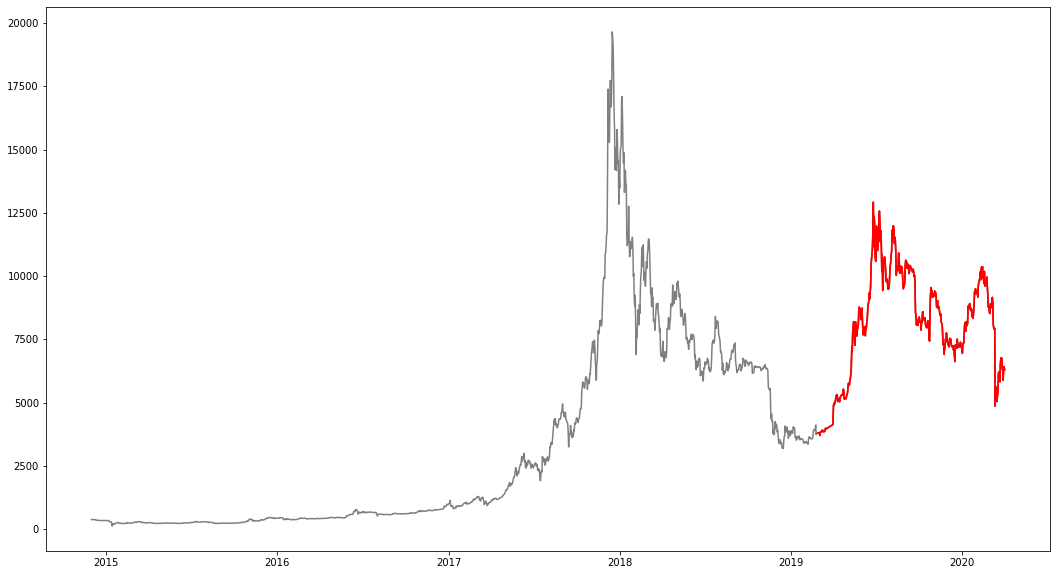

len 387 387
mape 32.08074930744547


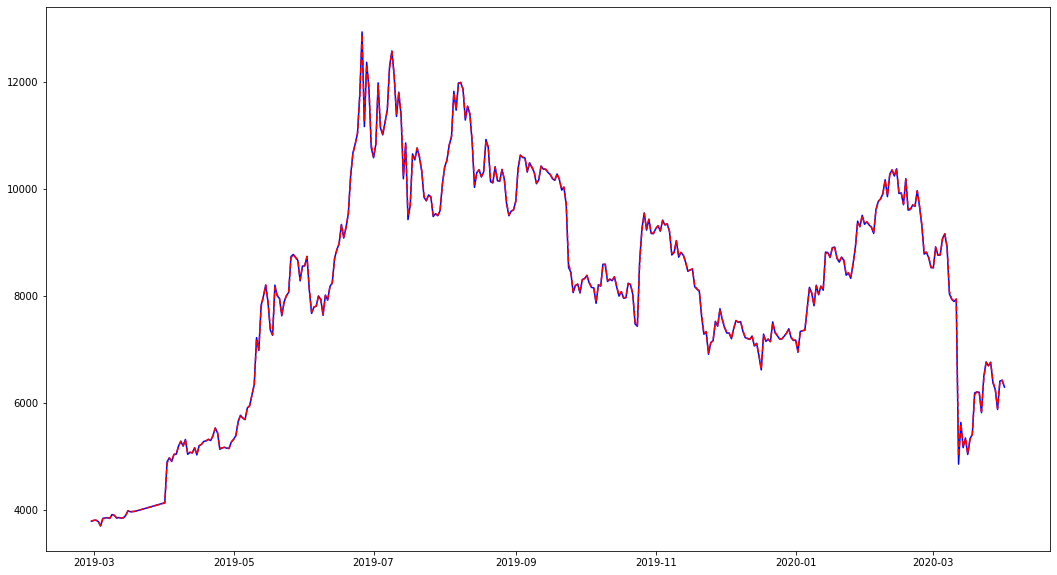

In [16]:
class ExponentialSmoothing(object):
    
    def __init__(self, df, percentage_train_size, list_alpha, list_beta):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.list_alpha = list_alpha
        self.list_beta = list_beta
        
    
    def mean_absolute_percentage_error(self, y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    def perform(self):
        
        best_params, last_index = self.create_model()
        
        array_pred = np.array([])
        
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred = self.prediction(best_params = best_params, last_index = row[0])
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['Close'].values)

            
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.index[:-last_index], self.df['Close'].values[:-last_index], color="gray")
        ax.plot(self.df.index[-last_index:], self.df['Close'].values[-last_index:], label = 'Close', color="gray")
        ax.plot(self.df.index[-last_index:], self.df.iloc[-last_index:]['Close'].values, color = 'r')
        ax.plot(self.df.index[-last_index:], array_pred.reshape(-1, 1), label="alpha="+str(best_params[0])+", beta="+str(best_params[1]), color = 'r')
        ax.legend()
        plt.show()
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        mape = self.mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred)
        print('mape', mape)
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        ax.legend()
        plt.show()
        
        return True
    
    def prediction(self, best_params, last_index):
        
        model = Holt(np.asarray(self.df[:last_index]))
                
        fit_model = model.fit(smoothing_level = best_params[0], smoothing_slope = best_params[1])
        pred = fit_model.forecast( steps = 1)
        
        return pred
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        model = Holt(np.asarray(self.df.iloc[:-last_index]))
        best_aic = np.inf
        best_fit = 0
        
        for alpha in self.list_alpha:
            
            for beta in self.list_beta:
            
                fit_model = model.fit(smoothing_level = alpha, smoothing_slope = beta)
                
                if fit_model.aic < best_aic:
                    best_aic = fit_model.aic
                    best_fit = fit_model
                    best_params = (alpha, beta)
        
        print('AIC', best_aic, 'best_params', best_params)
        
        return best_params, last_index

### MAIN

#df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])

days = 1
list_alpha = [a/100 for a in range(0, 100, 5)]
list_beta = [b/100 for b in range(0, 100, 5)]
exponential_smoothing = ExponentialSmoothing(df = df,
                                             percentage_train_size = 0.80, 
                                             list_alpha = list_alpha, 
                                             list_beta = list_beta
                                            )
_ = exponential_smoothing.perform()


In [ ]:
#mape 32.08074930744547
#387 dias
#80% de treino
#best params (0.95, 0.0)
#AIC 17288.24

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


self.df head           ds        y
4 2020-03-28  6251.82
3 2020-03-29  5877.21
2 2020-03-30  6406.40
1 2020-03-31  6424.35
0 2020-04-01  6295.77
head
            ds        y
18 2020-03-14  5165.25
future
              ds
1919 2020-03-15
forecast
 ds      2020-03-15 00:00:00
yhat                9465.82
Name: 1919, dtype: object
yhat
 9465.819669380888
last_index 2020-03-14 00:00:00
pred 9465.819669380888
head
            ds        y
17 2020-03-15  5345.35
future
              ds
1920 2020-03-16
forecast
 ds      2020-03-16 00:00:00
yhat                9436.19
Name: 1920, dtype: object
yhat
 9436.193885893908
last_index 2020-03-15 00:00:00
pred 9436.193885893908
head
            ds        y
16 2020-03-16  5037.61
future
              ds
1921 2020-03-17
forecast
 ds      2020-03-17 00:00:00
yhat                9322.86
Name: 1921, dtype: object
yhat
 9322.861594527953
last_index 2020-03-16 00:00:00
pred 9322.861594527953
head
            ds        y
15 2020-03-17  5331.71
future
          

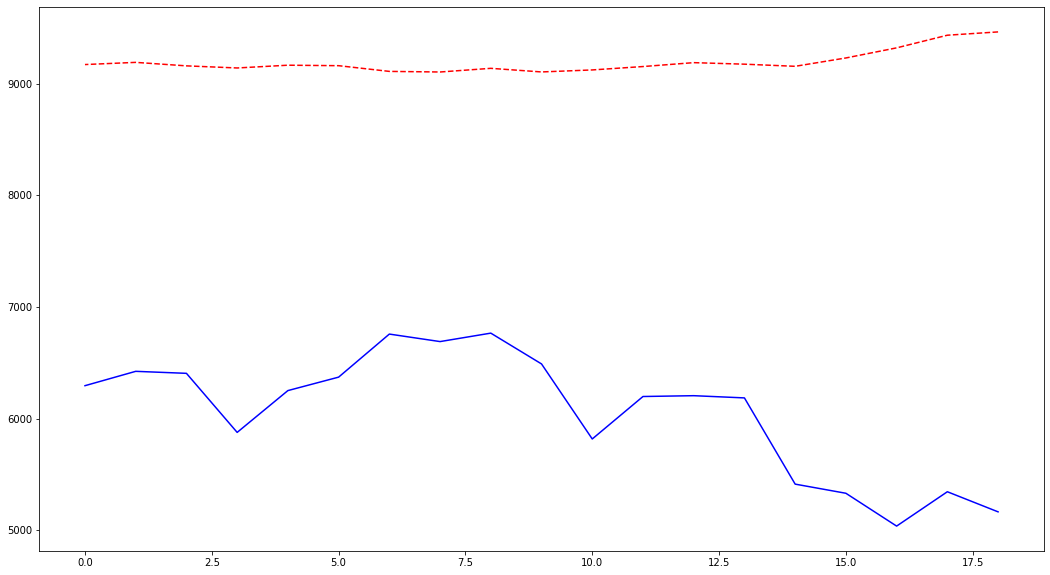

In [12]:
class ProphetForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        self.df.columns = ['ds', 'y']
        print('self.df head', self.df.tail())
        best_order, last_index = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
    
            pred = self.prediction(best_order = best_order, last_index = row[1])
            array_pred = np.append(array_pred, pred)
            print('last_index', row[1])
            print('pred', pred)
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['y'].values)
        
        y_true = self.df.iloc[-last_index:]['y'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        mape = self.mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred)
        print('mape', mape)
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def mean_absolute_percentage_error(self, y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    def prediction(self, best_order, last_index):
        
        model = Prophet(daily_seasonality=True)
        model.fit(self.df[ self.df['ds'] <= last_index])
        future = model.make_future_dataframe(periods=1, freq='D')
        print('head\n', self.df[ self.df['ds'] <= last_index].tail(1))
        print('future\n', future.tail(1))
        forecast = model.predict(future)
        print('forecast\n', forecast.iloc[-1][['ds', 'yhat']])
        print('yhat\n', forecast.iloc[-1]['yhat'])
        return forecast.iloc[-1]['yhat']
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None
        #otimizar treino não implementado
        #yearly_seasonality = False, daily_seasonality = False, weekly_seasonality = False    
        m = Prophet()
        m.fit(self.df[:-last_index])

            
#             tmp_aic = results.aic
#             if tmp_aic < best_aic:
#                 best_aic = tmp_aic
#                 best_order = (i, d, j)
#                 best_mdl = mod #não esta sendo utilizado

#         print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return None, last_index
    
### MAIN

#df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

#df = df.set_index('Date')
df = df[['Date', 'Close']]
df = df.sort_values(by = ['Date'])


prophet_forecast = ProphetForecast(df = df, 
                                    percentage_train_size = 0.99)
prophet_forecast.perform()

